# Setup

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

import ipywidgets as widgets

# modeling
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima.datasets import load_lynx
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split

from utils import plot_acf_pacf, adf_test, kpss_test


# path handling
from pathlib import Path
from utils import metrics, load_last_final_data

# filter warnings
import warnings
warnings.filterwarnings("ignore")

# Data

Read saved static data (csv file) of COVID-19 cases in Spain. More info in https://cnecovid.isciii.es/covid19/#documentaci%C3%B3n-y-datos. 

<AxesSubplot:xlabel='Date'>

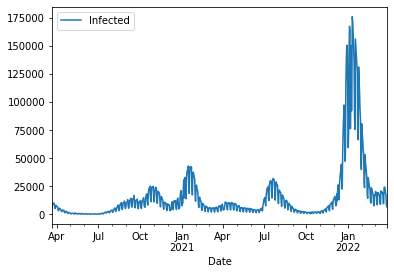

In [45]:
df = load_last_final_data(from_folder='processed')
df = df[['Infected']][20:]
df.plot()

**Interpretation of the line plot**

From the above graph, it can be concluded that:
1. The data show positive and strong autocorrelation.
2. Apparently, there is no significant trend. 
3. Seasonal patterns are found each 7 days (weekly).

# ARIMA
The first stage is model identification or obtaning initial guesses for the ARIMA parameters $p, d, q$. Identification is a necessarily inexact procedure, where graphical methods are of particular interest. Preliminary identification comes together with estimation to provide a first class of models to be fitted and diagnosed.

The objective is to identify a suitable subclass of models from the general ARIMA models family, formally expressed as:
$
\begin{equation}
\phi(B) \nabla^{d} z_t = \theta_0 + \theta(B)a_t.
\end{equation}
$
The time series could then be described by this model.

For this purpose, the following approach is used:
1. Produce stationarity by differencing the series $z_t$ as many times as necessary. This would reduce the underlying process to the mixed autorregressive-moving average process:
$
\begin{equation}
\phi(B) w_t = \theta_0 + \theta(B)a_t.
\end{equation}
$
where $w_t=(1-B)^{d}z_t = \nabla^{d}z_t$.
2. Identify the ARMA process.

Autocorrelation and partial autocorrelation functions (and plots) will shed light on which initial parameters to take.

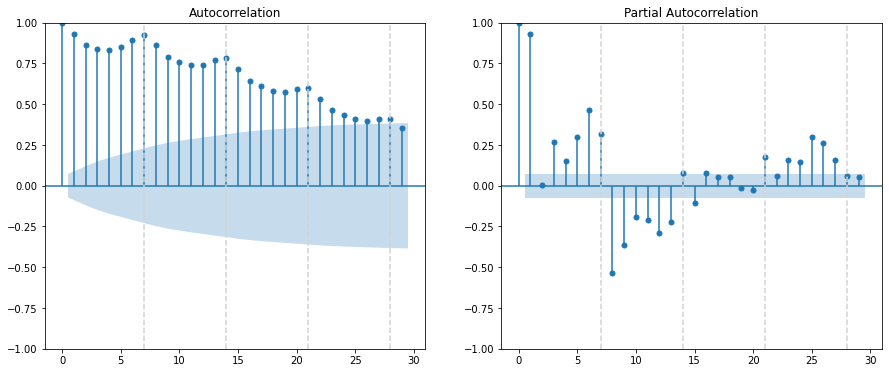

In [46]:
plot_acf_pacf(df)

**Interpretation of the autocorrelation plot**

The autocorrelation plot above shows that:
1. The sample autocorrelations are very strong and positive.
2. The sample autocorrelations decay slowly with lags.
3. Peaks are seen in the multiplies of 7, indicating seasonality.

<!-- The standard error at a lag $k$ is found under the assumption that
right model is an MA(k-1). This allows the possible interpretation: if all autocorrelations past a certain lag are within the limits, the model might be an MA of order defined by the last significant autocorrelation. -->

Failure of the estimated autocorrelation function to die out rapidly suggests that the underlying stochastic process might be treated as nonstationary in $z_t$ but possibly as stationary in $\nabla z_t$.

From the above, it follows that a certain degree of differentiation $d$ is needed to achieve stationarity. The nonstationary series will have been transformed into a stationary one when the autocorrelation function of $w_t=\nabla^{d}z_t$ for some $d$ (usually $d=1$ or $d=2$) dies out quickly.

## Stationarity

In order to adjust a statistical model, we must ensure first that the timeseries is stationary. Stationarity means that the statistical properties such as mean, variance and covariance of a timeseries do not change over time. Equivalently: the properties of the series do not depend on the instant of time (time-invariant).

It the timeseries is not stationary, its properties can vary with time. Thus, the properties used at time $t$ to make a prediction at $t+k$ may be different from those observed in that prediction and therefore inaccurate.

### Tests for checking stationarity

To check the stationarity of the timeseries, two statistical tests are carried out in parallel:
1. Augmented Dickey Fuller (ADF) test: this test is used determine whether a unit root exists in a series, and thus helps to understand whether the series is stationary. 
    - Null Hypothesis: The series has a unit root (timeseries is **not** stationary).
    - Alternate Hypothesis: The series has no unit root (timeseries is stationary).
    - Results: If p-value of the test is less than significance level (p-value<$\alpha$ = 0.05), then the null hypothesis is rejected and infers that timeseries is stationary. If p-value>$\alpha$, the timeseries is not stationary and a differentiation order must be found.

2. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test: another test to check the stationarity of time series. The hypothesis for this test are opposite that of the ADF test.
    - Null Hypothesis: The process is trend stationary.
    - Alternate Hypothesis: The series has a unit root (series is not stationary).
    - Results: If p-value of the test is less than significance level (p-value<$\alpha$ = 0.05), then timeseries is not stationary. If p-value>$\alpha$, the timeseries is stationary and a differentiation order must be found.

Results must be interpreted as follows:
- Case 1: Both tests conclude that the series is not stationary - The series is not stationary
- Case 2: Both tests conclude that the series is stationary - The series is stationary
- Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
- Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.


### Tests for checking seasonal stationarity
To check the seasonal stationarity of the timeseries, two statistical tests are carried out in parallel:
1. Osborn-Chu-Smith-Birchenhall (OCSB) test: test for seasonal unit root roots in a time series. Determines whether it needs seasonal differencing. The hypothesis are:
    - Null Hypothesis: the series contains a seasonal unit root (timeseries is not seaonal stationary).
    - Alternate Hypothesis: the series does not contain a seasonal unit root (timeseries is seasonal stationary).

2. Canova-Hansen (CH) test: test for seasonal differences. 
    - Null Hypothesis: the seasonal pattern is stable over time
    - Alternate Hypothesis: the seasonal pattern is unstable over time

In [47]:
# test stationarity on the original series
print('Stationarity tests on the original series:')
adf_test(df,  print_only_result=False)
kpss_test(df, print_only_result=False)

Stationarity tests on the original series:

ADF Test Results
-----------------
ADF Statistic: -4.110916686842014
p-value: 0.0009290565341408962
num lags: 20
Critical Values:
	1% : -3.4395289262948894
	5% : -2.8655907692307694
	10% : -2.5689271030368235
Result: The timeseries is stationary

KPSS Test Results
-----------------
KPSS Statistic: 0.8536113971817108
p-value: 0.01
num lags: 17
Critical Values:
	10% : 0.347
	5% : 0.463
	2.5% : 0.574
	1% : 0.739
Result: The timeseries is not stationary


ADF test indicates stationarity but KPSS does not: the series is difference stationarity. The series with the first difference is studied now.

In [48]:
# test seasonal stationarity of the transformed series
OCSB_D_recommendation = pm.arima.OCSBTest(m=7).estimate_seasonal_differencing_term(df)
CH_D_recommendation = pm.arima.CHTest(m=7).estimate_seasonal_differencing_term(df)

print('Seasonal differencing term recommendation:')
print('-------------------------------------------')
print('OCSB:', OCSB_D_recommendation)
print('CH:', CH_D_recommendation)

Seasonal differencing term recommendation:
-------------------------------------------
OCSB: 0
CH: 0


The series does not require a seasonal difference.

### Differenced series

The plot below shows the differenced series for $d=1$. 

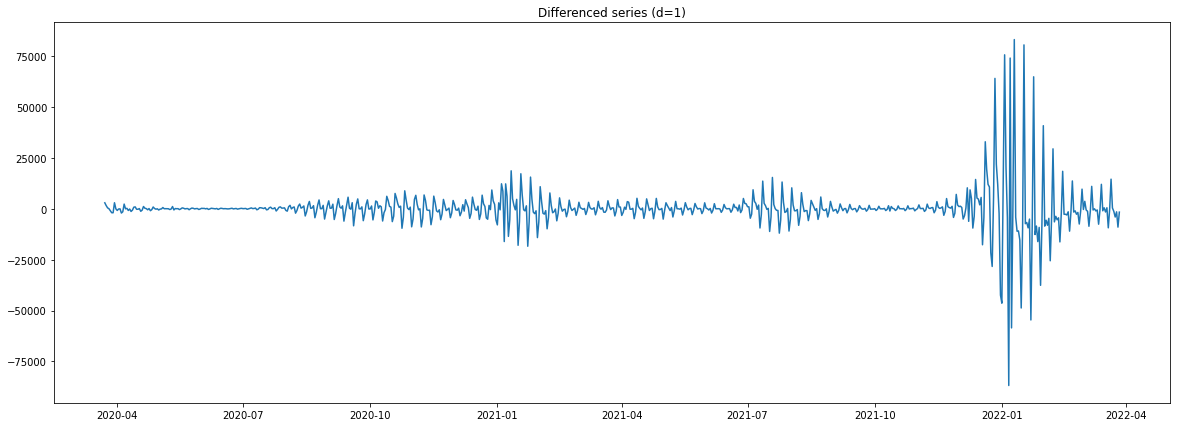

In [49]:
# take one difference (d=1)
df_d1 = df.diff().dropna()
# plot the differenced series
fig = plt.figure(figsize=(20, 7))
plt.title('Differenced series (d=1)')
plt.plot(df_d1)

**Interpretation of the differenced series**

The differenced series vary around zero (constant mean) now. However, it can be observed that the series fluctuates around this zero mean with a variable variance. Therefore, a logarithm transform of the observations has to be applied to stabilize the variance.

### Log transform

From the line graph of the initial series it can also be deduced that it is necessary to apply a transformation to the data. Since the seasonal effect appears to be multiplicative, a logarithmic transformation is recommended to make the seasonal effect additive (constant from period to period). However, it is important to take into account that this transformation will only stabilize the variance if the error term is also multiplicative. 

**Note:** This transformation has to be applied on the original series and then take the first difference on it; it would be absurd to apply the log transformation to the previous differenced series since it has zero values.

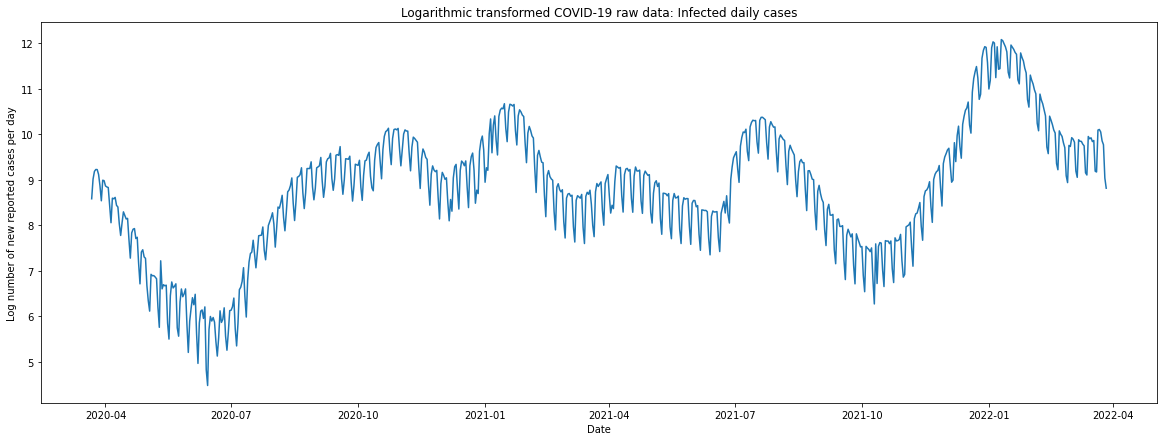

In [50]:
# apply a log transformation to the original data (having ensured that there is no zero value)
log_series = np.log(df)

# plot log-transformed data to confirm that the seasonal effect is now additive
fig = plt.figure(figsize=(20, 7))
plt.plot(log_series)
plt.xlabel('Date')
plt.ylabel('Log number of new reported cases per day')
plt.title('Logarithmic transformed COVID-19 raw data: Infected daily cases')
plt.show()

The log transformation appears to have been reasonable: the seasonal fluctuations are preserved but now they are in an additive fashion. 

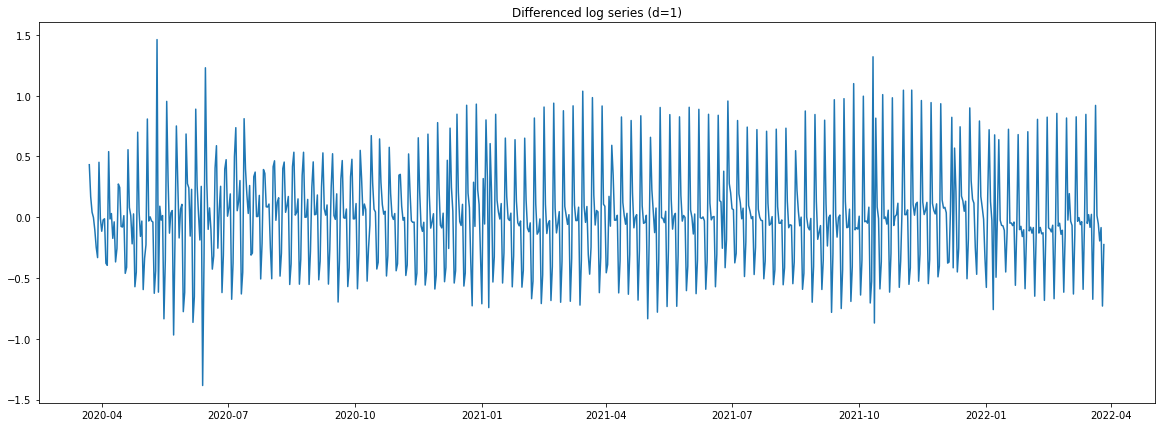

In [51]:
df = log_series.copy()
# difference the log series
df_d1 = df.diff().dropna()

# plot the resulting series
fig = plt.figure(figsize=(20, 7))
plt.title('Differenced log series (d=1)')
plt.plot(df_d1)

The graph above shows a more stationary version of the series is obtained: constant mean around zero, constant variance around the mean.

The next step now is to examine the ACF and PACF plots for the differenced series:

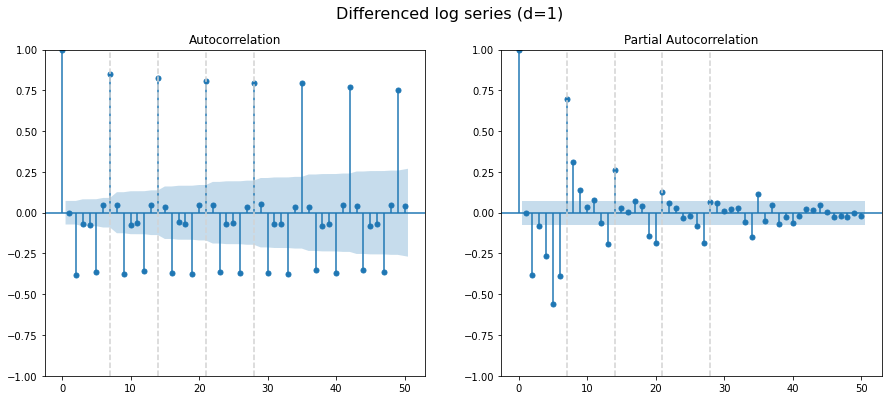

In [52]:
plot_acf_pacf(df_d1, 'Differenced log series (d=1)', lags=50)

The ACF shows constant peaks in the coefficients of 7, 14, ... lags, indicating the presence of a significant 7 period seasonal component. These seasonal components in the ACF remain constant with lag increase; in the PACF they tend to decay towards zero. The series does not exhibit stable seasonal behaviuor (oscillations), so there would be no need to take seasonal differences.

### Check stationarity of transformed series

Finally, the stationarity (regular and seasonal) of the transformed series should be checked. 

In [53]:
# test stationarity on the transformed series
print('Stationarity tests on the transformed series:')
adf_test(df_d1)
kpss_test(df_d1)

Stationarity tests on the transformed series:

ADF Test Results
-----------------
Result: The timeseries is stationary

KPSS Test Results
-----------------
Result: The timeseries is stationary


In [54]:
# test seasonal stationarity of the transformed series
OCSB_D_recommendation = pm.arima.OCSBTest(m=7).estimate_seasonal_differencing_term(df_d1)
CH_D_recommendation = pm.arima.CHTest(m=7).estimate_seasonal_differencing_term(df_d1)

print('Seasonal differencing term recommendation:')
print('-------------------------------------------')
print('OCSB:', OCSB_D_recommendation)
print('CH:', CH_D_recommendation)

Seasonal differencing term recommendation:
-------------------------------------------
OCSB: 0
CH: 1


Since the tests differ, a seasonal difference (m=7) is taken to explore the resulting timeseries and decide whether to keep the seasonal differenced or no. However, since the original serires did not require seasonal differences, the preferred approach is to keep the last series without seasonal difference.

**Seasonal difference**

The differenced series is now differenced with a 7 period difference (hence the 8 first observations of the original series are removed). After this operations, the log series is finally stationary, as can be observed in the graphs below.

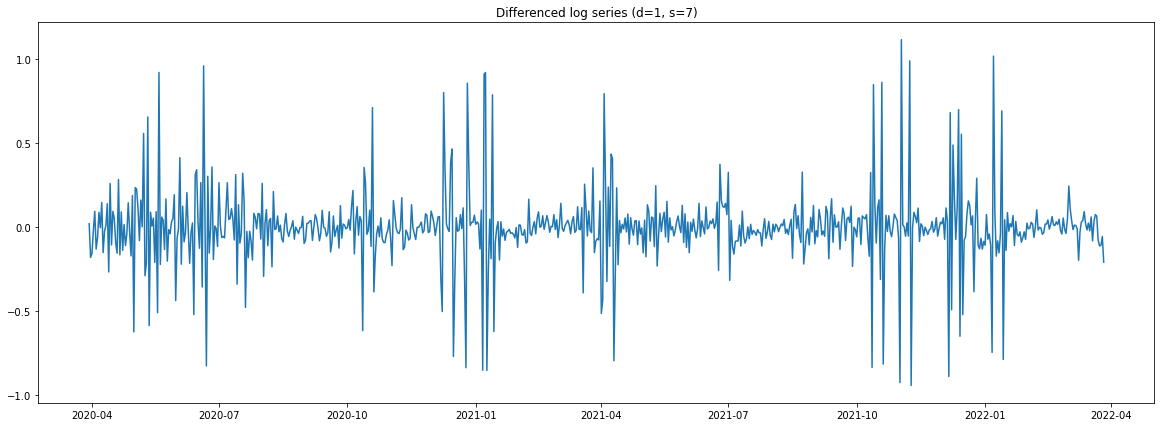

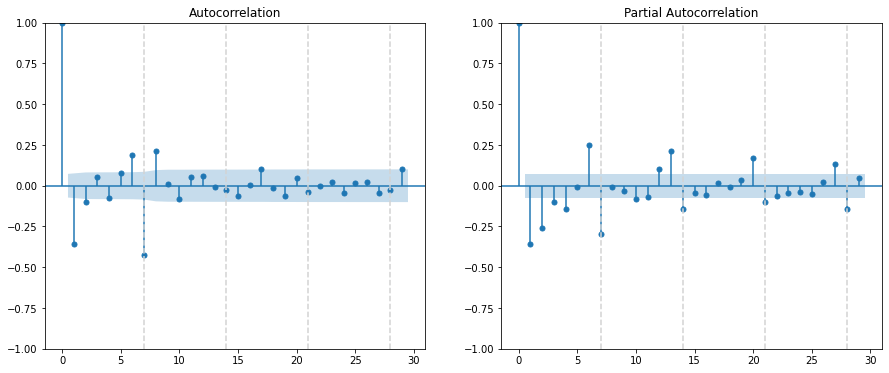

In [55]:
# take seasonal difference (s=7)
df_d1_s7 = df_d1.diff(7).dropna()
# plot the differenced series
fig = plt.figure(figsize=(20, 7))
plt.title('Differenced log series (d=1, s=7)')
plt.plot(df_d1_s7)
plot_acf_pacf(df_d1_s7)

**Interpretation of the graphs**

1. The line plot indicates that the series has lost the constant variance.
2. The first lag is significant and negative for both of the autocorrelation and partial autocorrelation plots. 
3. The lag 7 is significant and negative for both plots. Moreover, there is correlation in its vicinity.
4. Disregarding the peaks due to seasonality, after the first few lags the series decays to zero. This suggests a mixed ARMA model.
    <!-- - The significant spikes at lag 1 and lag 2 in ACF plot suggests a non-seasonal $MA(2)$ process and a seasonal $MA(1)$ process -->

When testing stationarity, the tests concludes that this series is stationary and seasonal stationary for both OCSB and CH tests, but the line plot suggests that the previous series (without seasonal differencing) could have better properties for the analysis.

In [56]:
# test stationarity on the differenced series
print('Stationarity tests on the diffrenced (d=1, s=7) log series:')
adf_test(df_d1_s7)
kpss_test(df_d1_s7)

# test seasonal stationarity of the transformed series
OCSB_D_recommendation = pm.arima.OCSBTest(m=7).estimate_seasonal_differencing_term(df_d1_s7)
CH_D_recommendation = pm.arima.CHTest(m=7).estimate_seasonal_differencing_term(df_d1_s7)

print('\n')
print('Seasonal differencing term recommendation:')
print('-------------------------------------------')
print('OCSB:', OCSB_D_recommendation)
print('CH:', CH_D_recommendation)

Stationarity tests on the diffrenced (d=1, s=7) log series:

ADF Test Results
-----------------
Result: The timeseries is stationary

KPSS Test Results
-----------------
Result: The timeseries is stationary


Seasonal differencing term recommendation:
-------------------------------------------
OCSB: 0
CH: 0


# Estimation of ARIMA models

Once the stationarity parameters (d, D) has been derived, a preliminary type of model should be provided and then the residuals must be studied to add to the previous model the structure that it was missing. 

Equivalently, the process of seeking the best order of parameters can be performed automatically. Given an information criterion (Akaike Information Criterion, Corrected Akaike Information Criterion, Bayesian Information Criterion, Hannan-Quinn Information Criterion, or “out of bag”–for validation scoring–respectively), different combinations of parameter orders are tested in order to minimize the value obtained with the criterion. This is the approach to be used. 

**Note:** It should be noted that, although there are functions capable of finding the optimal order of the parameters, it is not advisable to use them without previously knowing d and D. This is because the operation of differentiating converts one data series into a different one. Therefore, likelihood is calculated on two different series and, consequently, the values of the information criterion (commonly AIC or BIC) between models that have different orders of differencing cannot be compared. 
In definitive, this method is only recommended to find the order of p, q, P, Q.

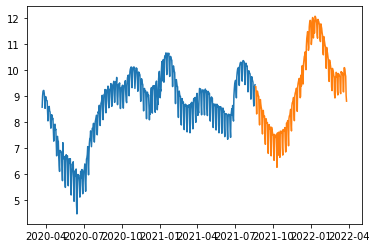

In [57]:
train, test = train_test_split(df, test_size=0.3)
plt.plot(train)
plt.plot(test)

In [58]:
# Fit your model
model = pm.auto_arima(np.array(train), 
                    seasonal=True, 
                    m=7, 
                    d=1, 
                    D=0, 
                    error_action='ignore', 
                    parallelized=True)

### Model Diagnostic Checking

Residuals are defined as the difference between the observations and the fitted values. They are indispensable to check whether a model captures all information in the data correctly. Visual inspection of a plot of the residuals themselves is an essential first step in the checking process. A forecasting method would be considered adequate if the resulting residuals verify the next properties:

1. Uncorrelation: If the residuals are autocorrelated, then the residuals still contain information left that should be added to the model.
2. Zero mean: Residuals with a mean other than zero indicate bias in forecasts.

If either of these properties is not satisfied, then the model can be modified to provide better forecasts. However, that does not mean that forecasting methods that satisfy these properties cannot be improved. Checking these properties is important in order to see whether a method is using all of the available information, but it is not a good way to select a forecasting method. 


In addition to the properties above, it is convenient (although not necessary) for the residuals to also have the following properties:

3. Homocedasticity (i.e, constant variance)
4. Normal distribution

However, a forecasting method that does not satisfy these properties cannot necessarily be improved. These additional properties are important in the calculation of prediction intervals.


#### ARIMA Results

The following tests and concepts will be used to ensure and verify the above.

- Ljung-Box Test: tests whether the errores are white noise by checking if the autocorrelations of the residuals are zero. It can be thought as a test of lack of fit: if the sample autocorrelations of residuals are close to zero, there is no missing structure to be added to the model and therefore it does not show significant lack of fit.
    - $H_0$: The residuals are independently distributed (autocorrelations in the population from which the sample is taken are zero; any observed aucorrelation in the residuals result from randomness of the sampling process). (the model is correctly fitted)
    - $H_1$: The residuals are not independently distributed (exhibit serial correlation).
    - A significant $p-$ value (<0.05) rejects $H_0$ that the autocorrelations are zero; $p-$ value>0.05 is sought in order not to reject $H_0$.


- Heteroskedasticity Test: test fot heteroskedasticity of standarized residuals; tests whether residuals are homocedastic (they have the same variance).
    - $H_0$: No heteroskedasticity.
    - $H_1$: Heteroskedasticity.
    - A significant $p-$ value rejects $H_0$ that the residuals are not heteroskedastic; $p-$ value>0.05 is preferred in order not to reject $H_0$.
    

- Jarque-Bera Test: test for normality of standarized residuals. As part of this test, skew and kurtosis are also computed. 
    - $H_0$: Normality.
    - $H_1$: No normality; residuals follow another distribution.
    - A significant $p-$ value rejects $H_0$ that the residuals are normally distributed; $p-$ value>0.05 is preferred in order not to reject $H_0$.


The stage of selecting the best model involves some probabilistic criteria, capable of measure model performance and model complexity on the training set. The actual value of the measure for a model is irrelevant on its own; the purpose of these criteria is the comparison of models. The following are displayed in the next analysis:
- Log likelihood: this function identifies the distribution that fits best the training data. The higher the value of the log-likelihood, the better a model fits a dataset. The log-likelihood value obtained can range from negative infinity to positive infinity. Adding predictor variables to a model will increase the log-likelihood value even if the additional predictor variables aren’t statistically significant, leading to overfitting.
- AIC (Akaike Information Criterion): Estimates the amount of information lost by a given model: the less information the model loses, the higher the quality of the model. AIC addresses the trade-off between model goodness of fit and model simplicity. In other words, AIC addresses the risk of overfitting and the risk of underfitting.
- BIC: Lower BIC models are usually preferred. It is partly based on probability functions and is closely related to the AIC. When fitting the model, the likelihood can be increased by adding parameters, but this can lead to overfitting. Both BIC and AIC attempt to address this problem by introducing a penalty term for the number of parameters in the model; BIC has a larger penalty term than AIC.
- HQIC: As in AIC, HQC introduces a penalty term for the number of parameters in the model, but the penalty is greater than one in AIC. The model with the lower HQC value is preferred; a lower HQC implies a smaller number of explanatory variables, better fit, or both. In practice, it seems to have seen little use.

In [59]:
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  515
Model:             SARIMAX(2, 1, 1)x(2, 0, 1, 7)   Log Likelihood                 185.123
Date:                           Sat, 16 Jul 2022   AIC                           -356.246
Time:                                   11:23:43   BIC                           -326.551
Sample:                                        0   HQIC                          -344.608
                                           - 515                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0049      0.116      0.042      0.966      -0.222       0.232
ar.L2         -0.1783      0.046     -3.890

#### Interpretation of model results
 
Residuals diagnostic:

- Ljung-Box (L1) (Q) is the Ljung-Box test at lag 1. The value of the statistic is 0.00 and the $p$ -value is 0.97>0.05. This implies that the $H_0$ is not rejected and therefore the residuals are white noise.
- Heteroskedasticity (H). The test statistic is 0.50 and the $p$ -value is 0<0.05. This implies that the $H_0$ is rejected and therefore the residuals are heteroskedastic.
- Jarque-Bera (JB) statistic is 484.72 and the $p$ -value is 0<0.05. This implies that the $H_0$ is rejected and therefore the residuals are not normally distributed. In addition, the residuals have a slight negative skew and a pretty large kurtosis.

https://robjhyndman.com/hyndsight/tests2/ (why not to use significance to choose variables in arima)

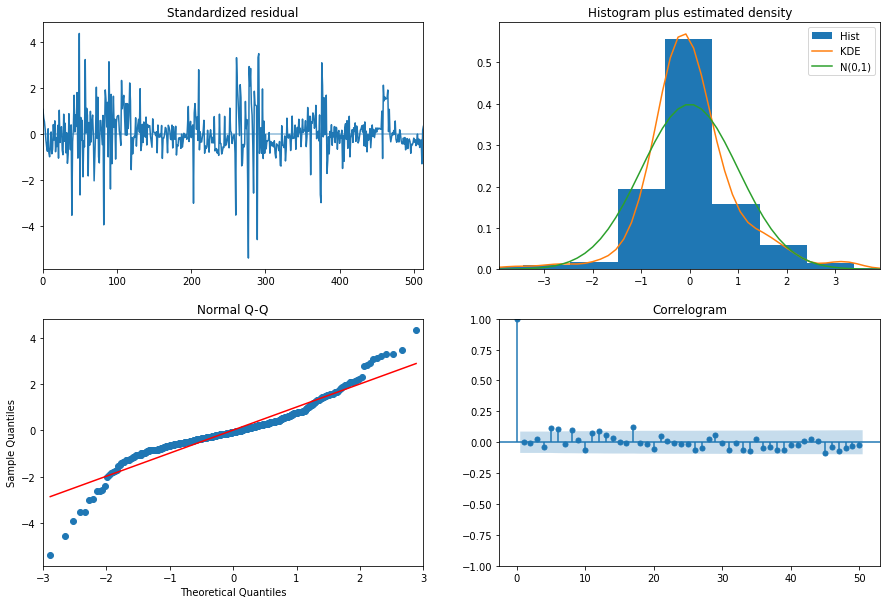

In [83]:
model.plot_diagnostics(figsize=(15,10), lags=50)
plt.show()

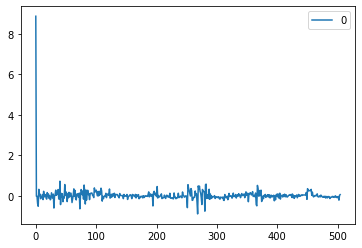

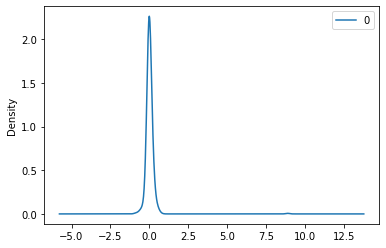

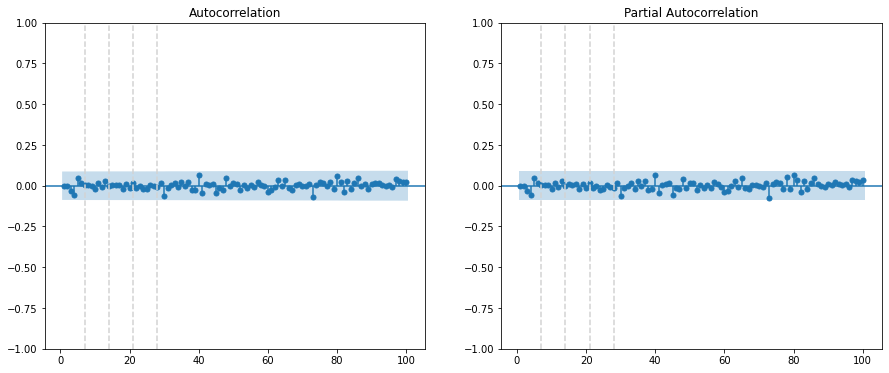

                0
count  505.000000
mean     0.020836
std      0.429447
min     -0.896090
25%     -0.076271
50%     -0.009604
75%      0.067636
max      8.862625


In [28]:
# line plot of residuals
residuals = pd.DataFrame(model.resid())
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
plot_acf_pacf(residuals, zero=False, auto_ylims=False, lags=100 )
plt.show()
# summary stats of residuals
print(residuals.describe())

# Validation

In [58]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            Infected   No. Observations:                  722
Model:             SARIMAX(0, 1, 0)x(2, 0, [1], 7)   Log Likelihood                 179.240
Date:                             Sat, 16 Jul 2022   AIC                           -350.480
Time:                                     01:47:41   BIC                           -332.158
Sample:                                 03-22-2020   HQIC                          -343.407
                                      - 03-13-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        1.2033      0.037     32.405      0.000       1.131       1.276
ar.S.L14      -0.2061      0.036     -5.656      0.000      -0.277      -0.135
ma.S.L7       -0.8707      0.025    -35.415      0.000      -0.919      -0.823
sigma2         0.0348      0.001     40.135      0.000       0.033       0.036
===================================================================================
Ljung-Box (L1) (Q):                  62.33   Jarque-Bera (JB):              1939.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                             0.22
Prob(H) (two-sided):                  0.09   Kurtosis:                        11.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

                                     SARIMAX Results                                     
Dep. Variable:                          Infected   No. Observations:                  722
Model:             SARIMAX(1, 1, 1)x(2, 0, 1, 7)   Log Likelihood                 228.549
Date:                           Sat, 16 Jul 2022   AIC                           -445.099
Time:                                   10:59:36   BIC                           -417.615
Sample:                               03-22-2020   HQIC                          -434.489
                                    - 03-13-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0965      0.056      1.737      0.082      -0.012       0.205
ma.L1         -0.4981      0.056     -8.825

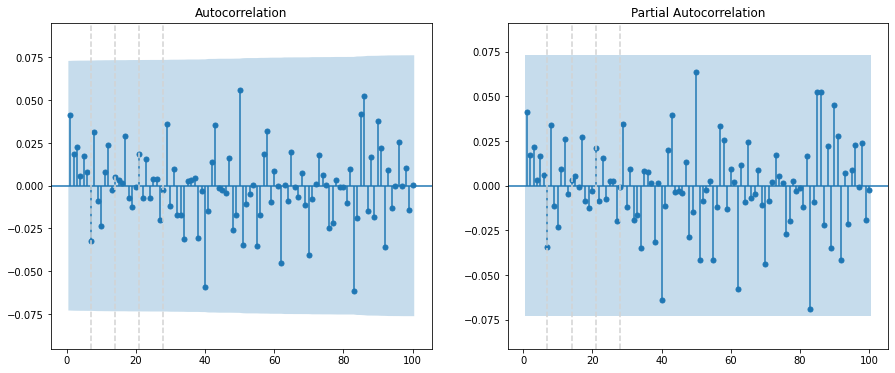

In [25]:
# fit model
# order = (0, 1, 0) # (p, d, q)
order = (1, 1, 1)
# seasonal_order = (1, 0, 1, 7) # (P, D, Q, s)
seasonal_order = (2, 0, 1, 7)
model = SARIMAX(df[:-14], order=order, seasonal_order=seasonal_order)
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
# residuals.plot()
# plt.show()
# # density plot of residuals
# residuals.plot(kind='kde')
# plt.show()
plot_acf_pacf(residuals, zero=False, auto_ylims=True, lags=100)
plt.show()

https://www.itl.nist.gov/div898/handbook/pmc/section6/pmc622.htm

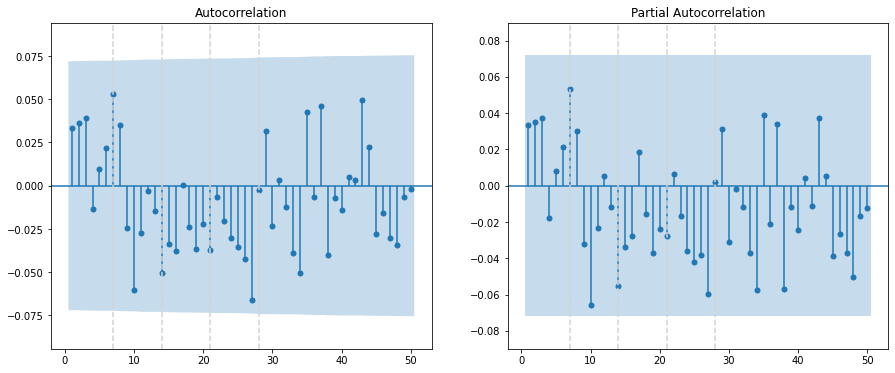

In [74]:
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit model
order = (1, 1, 3) # (p, d, q)
seasonal_order = (1, 0, 1, 7) # (P, D, Q, s)
model = SARIMAX(df[:-14], order=order, seasonal_order=seasonal_order)
model_fit = model.fit()
# summary of fit model
# print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
# residuals.plot()
# plt.show()
# # density plot of residuals
# residuals.plot(kind='kde')
# plt.show()
plot_acf_pacf(residuals, zero=False, auto_ylims=True, lags=50)
plt.show()
# summary stats of residuals
# print(residuals.describe())

In [13]:
forecast = model_fit.get_forecast(14)

## Interpretation of results
https://analyzingalpha.com/interpret-arima-results




predicted=10.329070, expected=10.256922
predicted=10.354331, expected=10.306917
predicted=10.291054, expected=10.295496
predicted=10.344237, expected=10.300920
predicted=9.785447, expected=9.829787
predicted=9.571780, expected=9.582869
predicted=10.341979, expected=10.303907
predicted=10.444496, expected=10.369766
predicted=10.422165, expected=10.371019
predicted=10.362020, expected=10.345156
predicted=10.363707, expected=10.317020
predicted=9.815688, expected=9.810714
predicted=9.542263, expected=9.451167
predicted=10.224295, expected=10.158517
predicted=10.296136, expected=10.273982
predicted=10.283821, expected=10.208174
predicted=10.192089, expected=10.153779
predicted=10.167529, expected=10.159098
predicted=9.631718, expected=9.605014
predicted=9.276348, expected=9.171496
predicted=9.943507, expected=9.896211
predicted=10.052629, expected=9.982899
predicted=9.963662, expected=9.934065
predicted=9.902195, expected=9.884509
predicted=9.897978, expected=9.862249
predicted=9.320628, e

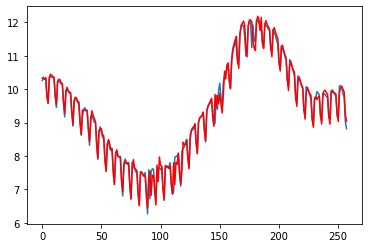

In [83]:
from sklearn.metrics import mean_squared_error
from math import sqrt
order = (2,1,2)
seasonal_order = (1,1, 1, 7)

# split into train and test sets
series = df
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = SARIMAX(history, order=order, seasonal_order=seasonal_order)
	model_fit = model.fit()
	output = model_fit.forecast(steps=1)
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
rmsle = metrics['RMSLE']
print(f'RMSLE: {rmsle(test, predictions)}')
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

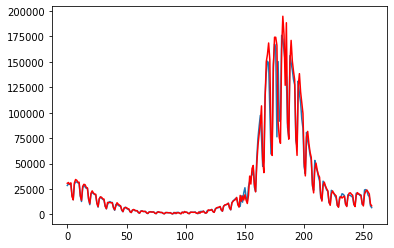

In [86]:
plt.plot(np.exp(test.ravel()))
plt.plot(np.exp(predictions), color='red') 
plt.show()

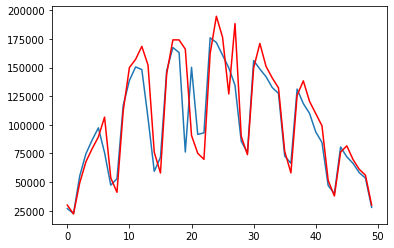

In [95]:
plt.plot(np.exp(pd.Series(test[-100:-50].ravel())))
plt.plot(np.exp(predictions[-100:-50]), color='red')

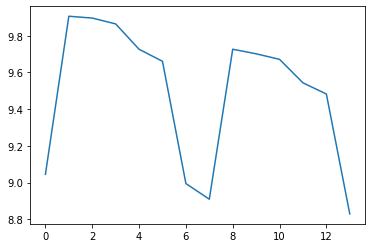

In [114]:
plt.plot(yhat)


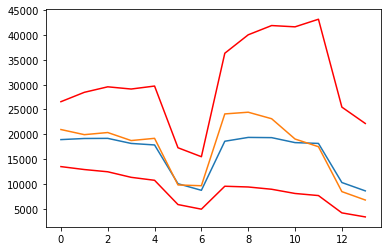

In [68]:
plt.plot(np.exp(yhat.values))
plt.plot(np.exp(yhat_ci[:, 0]), color='red')
plt.plot(np.exp(yhat_ci[:, 1]), color='red')
plt.plot(np.exp(df[-14:].values))


In [67]:
forecast = model_fit.get_forecast(14)
yhat = forecast.predicted_mean

yhat_ci = forecast.conf_int(alpha=0.05).values
print(np.exp(yhat_ci[0]), np.exp(yhat), np.exp(yhat_ci[1]))

[13455.38267424 26548.33644448] 2022-03-14    18900.212333
2022-03-15    19125.563051
2022-03-16    19150.152294
2022-03-17    18128.427604
2022-03-18    17822.097737
2022-03-19    10004.373590
2022-03-20     8673.384017
2022-03-21    18570.011448
2022-03-22    19342.878784
2022-03-23    19297.284312
2022-03-24    18292.998329
2022-03-25    18131.032710
2022-03-26    10243.275112
2022-03-27     8560.404257
Freq: D, Name: predicted_mean, dtype: float64 [12862.84718757 28437.49573248]


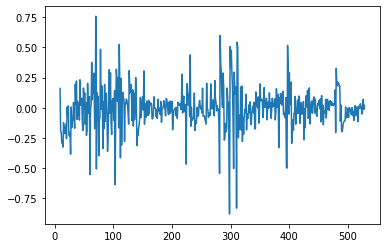

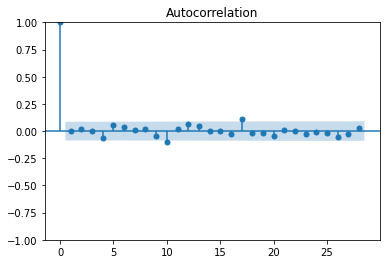

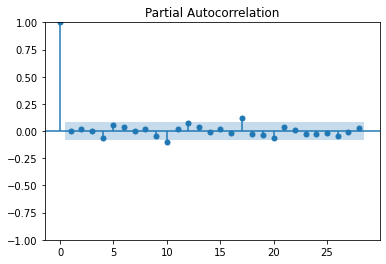

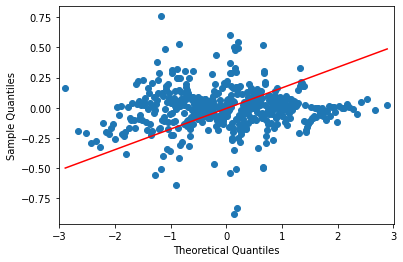

<AxesSubplot:ylabel='Density'>

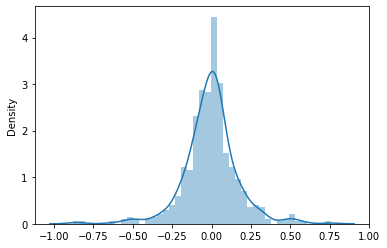

In [163]:
from statsmodels.graphics.gofplots import qqplot
# residuals = np.exp(test).ravel()-np.exp(predictions)
residuals = residuals[1:]
plt.plot(residuals)
plt.show()
plot_acf(residuals)
plt.show()
plot_pacf(residuals)
plt.show()
# sns.kdeplot(data=residuals)
# plt.hist(residuals, density=True)
plt.show()
qqplot(residuals, line='s')
plt.show()
sns.distplot(residuals)


https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

https://www.itl.nist.gov/div898/handbook/pmc/section6/pmc622.

https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf/notebook

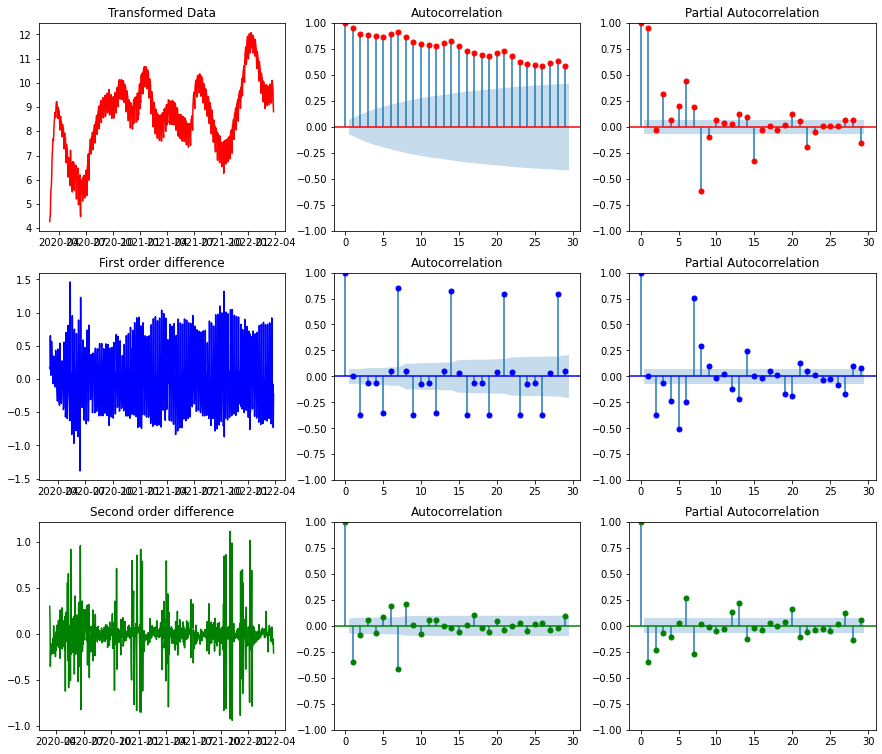

In [10]:
plt.rcParams['figure.figsize'] = [15, 13]

fig, ax = plt.subplots(3, 3)
ax[0, 0].plot(I, color='r')
ax[0, 0].set_title('Transformed Data')
plot_acf(I, ax=ax[0, 1], color='r')
plot_pacf(I, ax=ax[0, 2], color='r')


# first difference
diff_df = I.diff(1).dropna()
ax[1, 0].plot(diff_df, color='b')
ax[1, 0].set_title('First order difference')
plot_acf(diff_df, ax=ax[1, 1], color='b')
plot_pacf(diff_df, ax=ax[1, 2], color='b')

# second difference
diff_df_seasonal = I.diff(7).dropna().diff().dropna()
ax[2, 0].plot(diff_df_seasonal, color='g')
ax[2, 0].set_title('Second order difference')
plot_acf(diff_df_seasonal, ax=ax[2, 1], color='g')
plot_pacf(diff_df_seasonal, ax=ax[2, 2], color='g')

plt.show()

### AR(p) term



The next step is to identify if the model will need a AR term; the autocorrelation of any stationary series can be rectified by adding sufficient AR terms to the series. The Partial Autocorrelation plot (PACF) can shed light on how many AR terms the model will need. Initially, we take the AR order equal to the number of lags that cross the significance boundary of the PACF graph. 

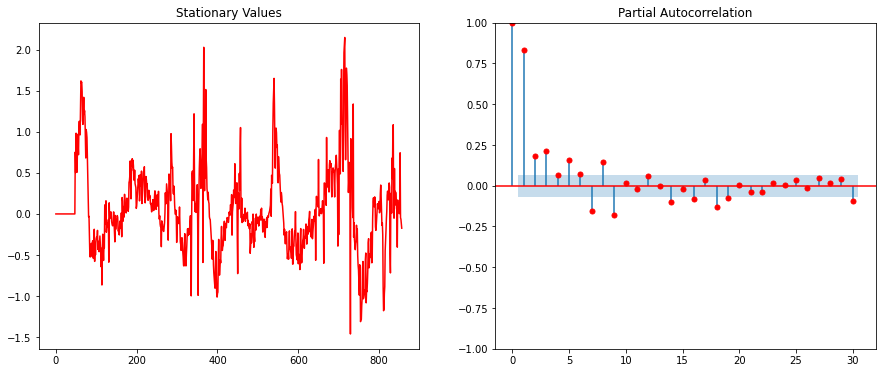

In [55]:
plt.rcParams['figure.figsize'] = [15, 6]
fig, ax = plt.subplots(1, 2)
ax[0].plot(I_st, color='r')
ax[0].set_title('Stationary Values')

plot_pacf(I_st, ax=ax[1], color='r')
plt.show()

========================================================

https://www.youtube.com/watch?v=xbqY485yslI&ab_channel=NarenCastellon


 We can see that the p-value of the first order differentiation is still greater than 0.05 and the p-value of the second order differentiation is finally less than 0.05. So the correct differentiation order could be $d=2$

Next we must identify if the model needs some AR term. This can be done inspecting the Partial Autocorrelation plot (PACF).

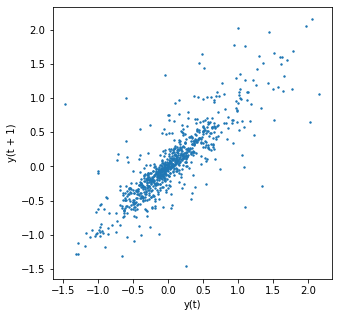

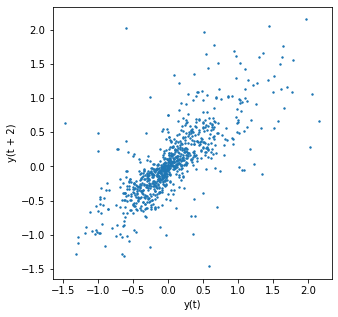

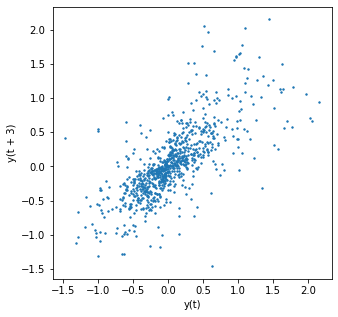

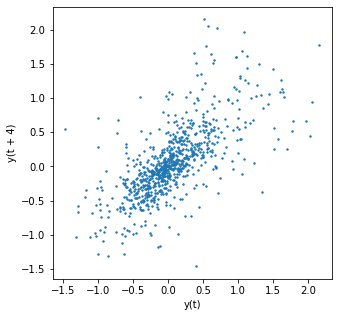

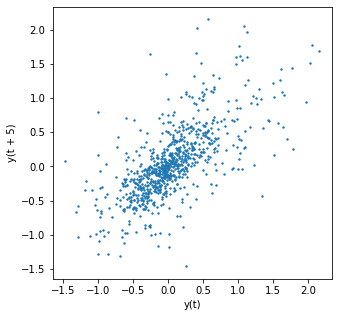

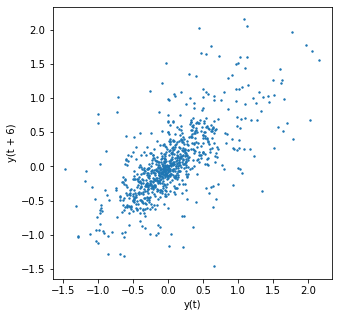

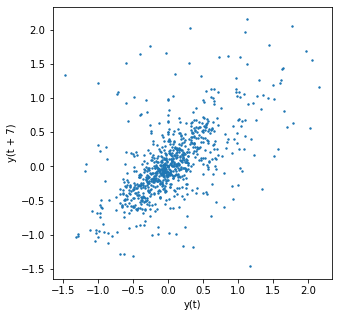

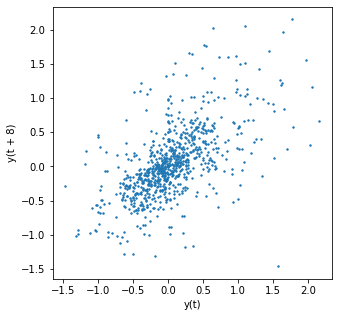

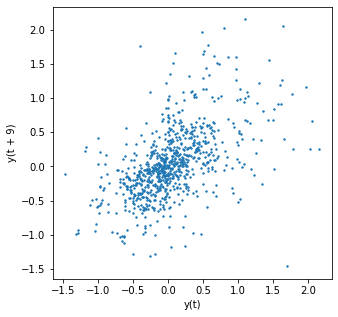

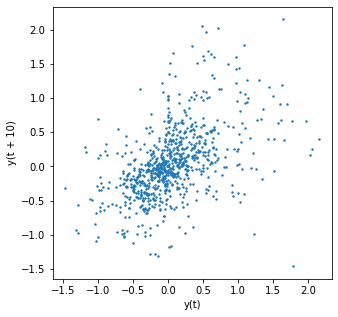

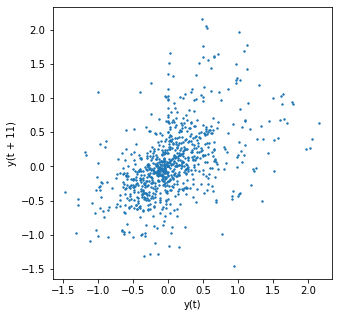

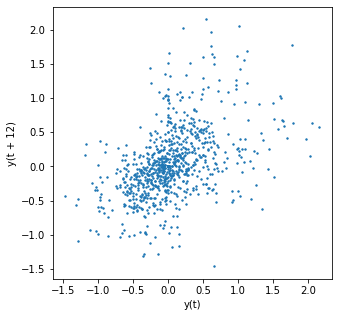

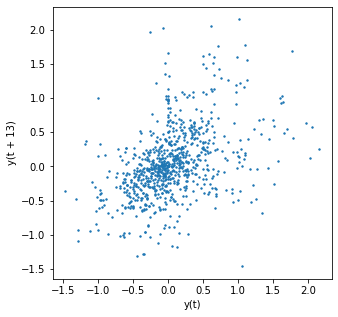

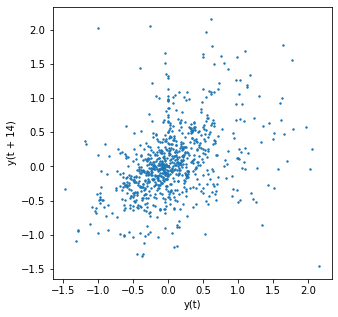

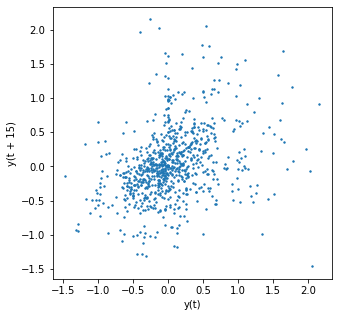

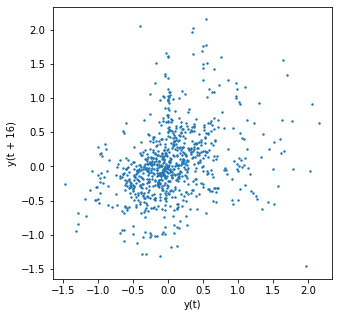

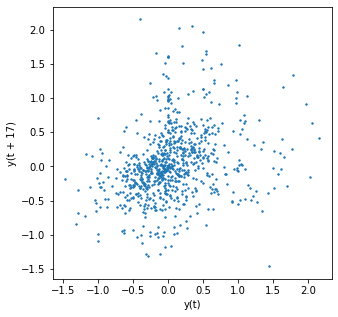

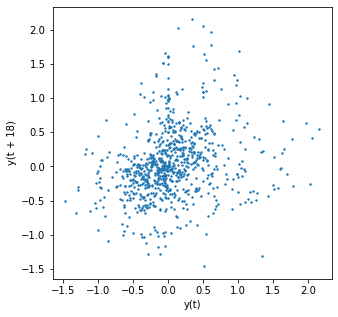

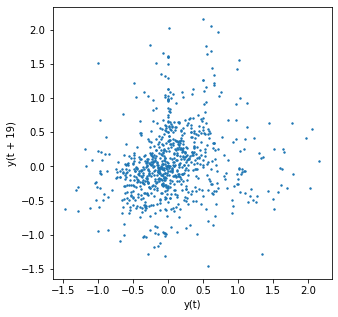

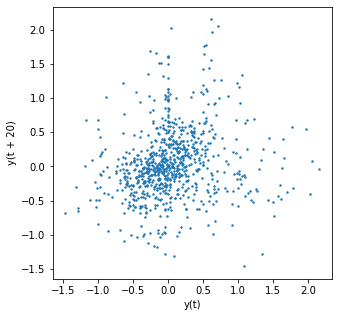

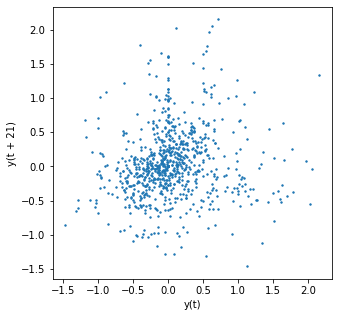

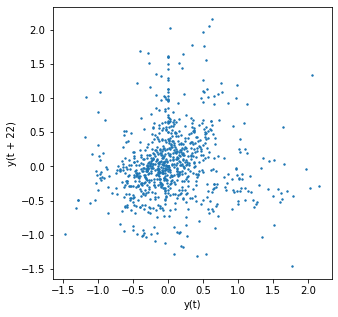

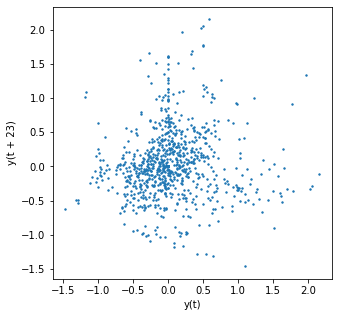

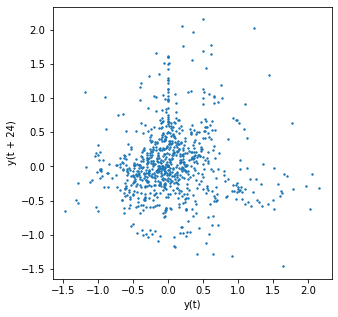

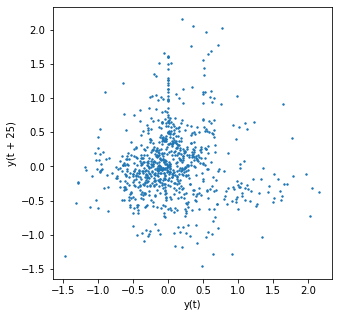

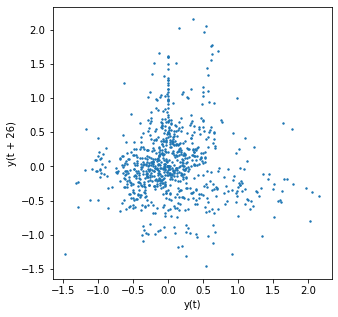

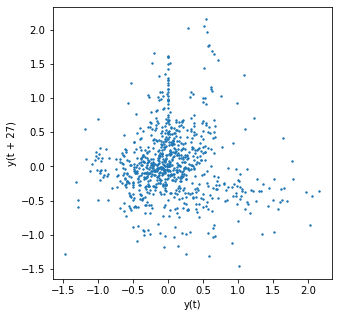

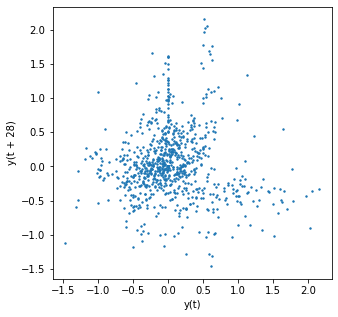

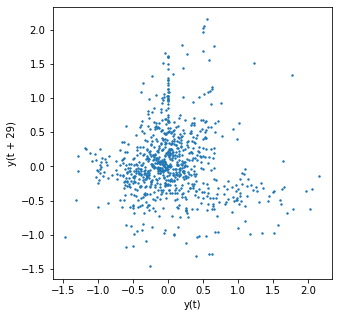

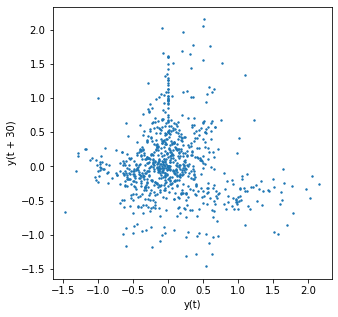

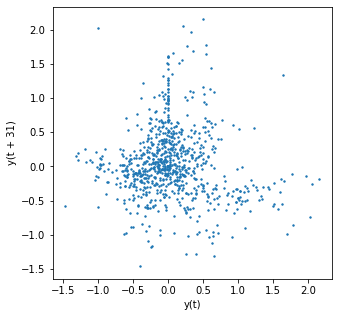

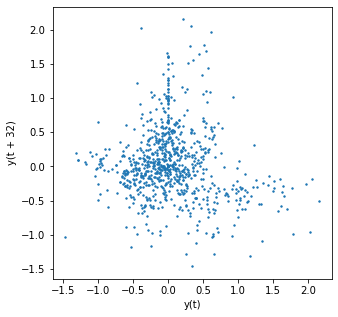

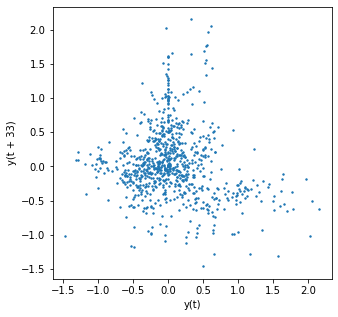

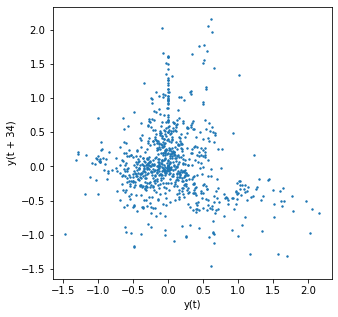

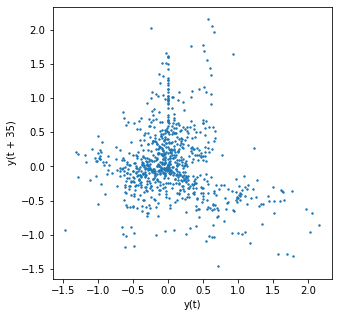

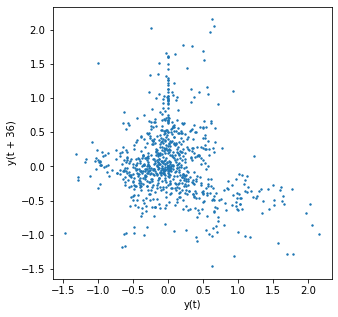

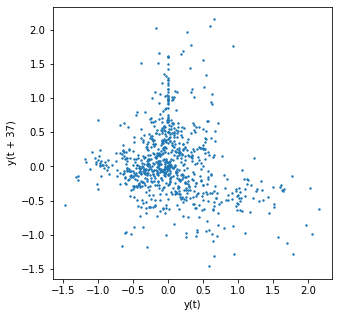

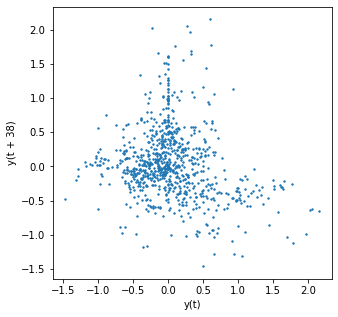

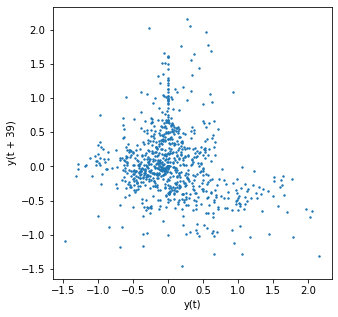

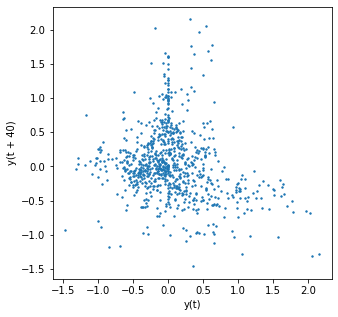

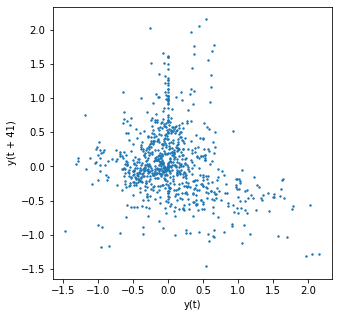

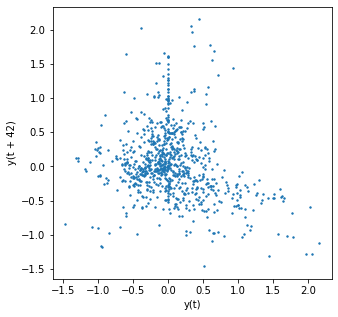

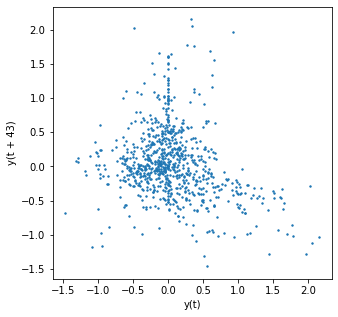

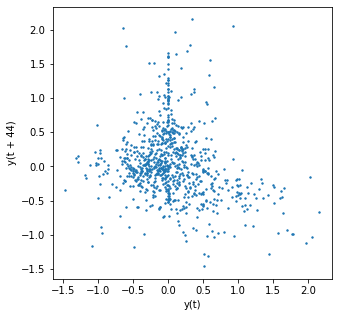

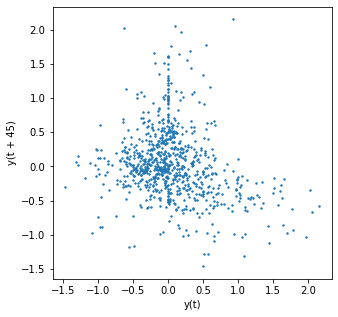

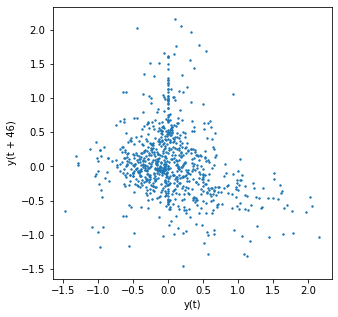

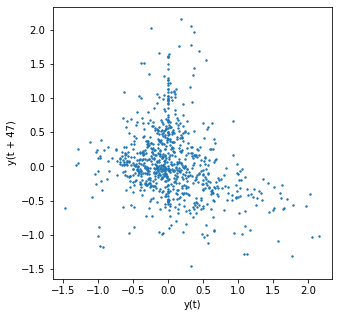

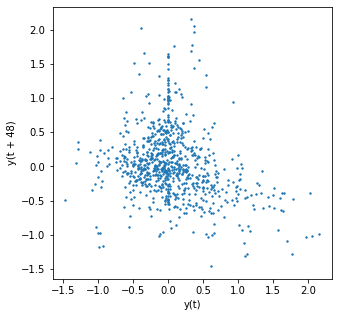

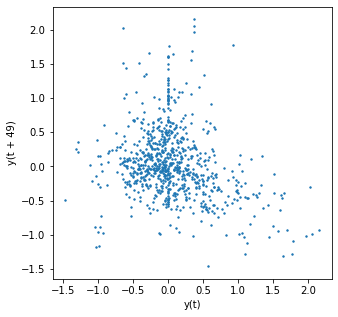

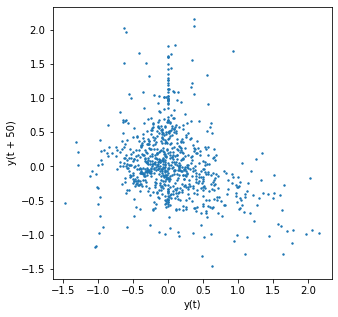

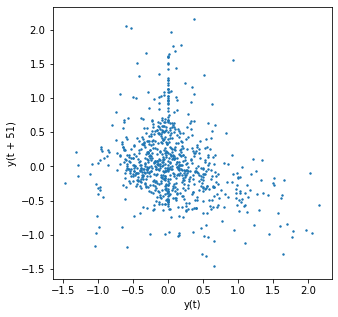

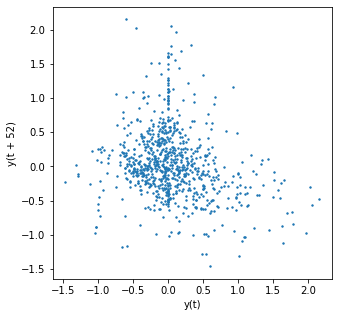

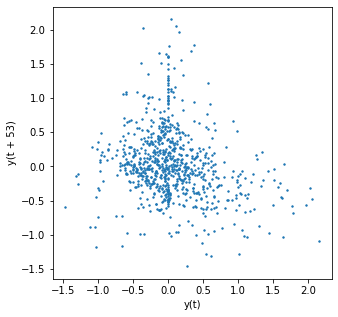

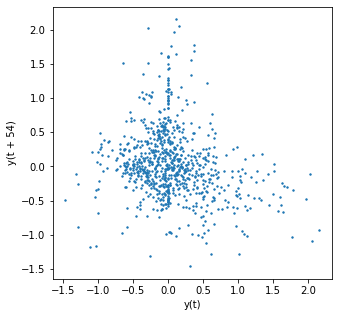

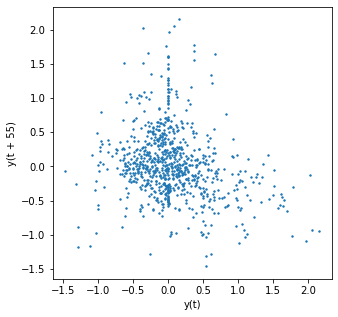

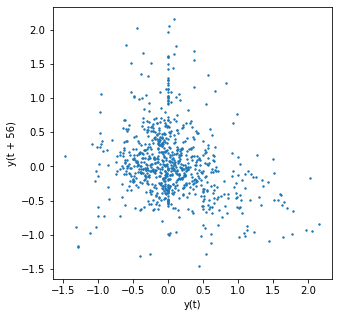

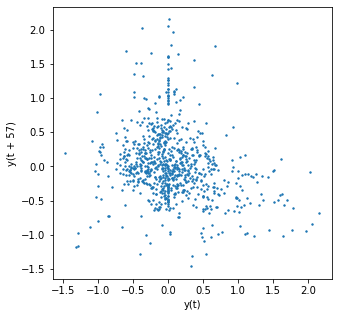

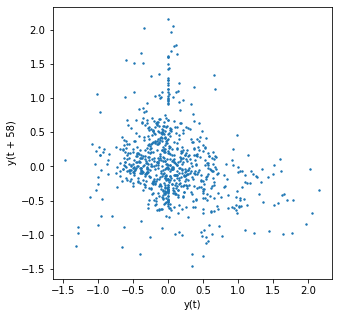

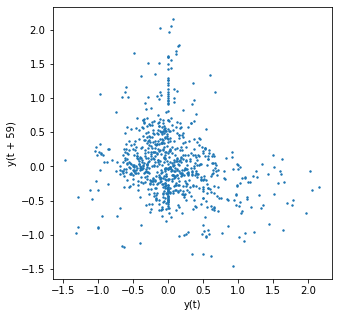

In [171]:
plt.rcParams['figure.figsize'] = [5, 5]

for lag in range(1, 60):
    pd.plotting.lag_plot(pd.Series(I).diff().dropna(), lag=lag, s=2)
    plt.show()

Lag plot showing a strong positive correlation of $t$ with $t+1$. That is, knowing $y(t)$ one can make a strong guess of $y(t+1)$. Since only successive observations appear to be correlated, the parameters of an autoregressive model are estimated.

In [137]:
df = pd.Series(I).diff().dropna()

train_df = df.iloc[:int(len(df)*0.9)]
test_df = df.iloc[int(len(df)*0.9):]

In [144]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

ar1_model = AutoReg(train_df.values.ravel(), 7)
results = ar1_model.fit()
print(results.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  771
Model:                     AutoReg(7)   Log Likelihood                 -52.097
Method:               Conditional MLE   S.D. of innovations              0.259
Date:                Tue, 14 Jun 2022   AIC                            122.194
Time:                        18:28:52   BIC                            163.941
Sample:                             7   HQIC                           138.266
                                  771                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.009      0.255      0.798      -0.016       0.021
y.L1           0.5918      0.036     16.546      0.000       0.522       0.662
y.L2           0.0491      0.041      1.192      0.2

In [145]:
select_model = ar_select_order(train_df.values.ravel(), maxlag=60)
print(select_model.ar_lags)

[1, 2, 3, 4, 5, 6, 7, 8, 9]


In [146]:
arp_model = AutoReg(train_df.values.ravel(), select_model.ar_lags)
model = arp_model.fit()
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  771
Model:                     AutoReg(9)   Log Likelihood                 -31.669
Method:               Conditional MLE   S.D. of innovations              0.252
Date:                Tue, 14 Jun 2022   AIC                             85.338
Time:                        18:28:54   BIC                            136.334
Sample:                             9   HQIC                           104.974
                                  771                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.009      0.335      0.737      -0.015       0.021
y.L1           0.6332      0.035     17.849      0.000       0.564       0.703
y.L2          -0.0163      0.041     -0.394      0.6

In [154]:
predictions = model.predict(start=len(train_df), end=len(train_df)+10)

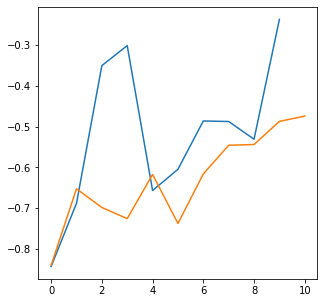

In [155]:
plt.plot(test_df.values.ravel()[:10])
plt.plot(predictions)
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

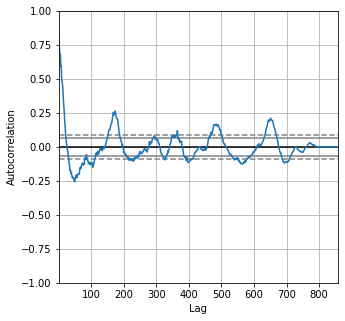

In [149]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df)